In [1]:
# Core
import pandas as pd
import numpy as np
import re

# ML
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Utils
import matplotlib.pyplot as plt
from google.colab import files
import joblib


In [2]:
# Upload the dataset
uploaded = files.upload()
csv_path = [k for k in uploaded.keys() if k.endswith('.csv')][0]
csv_path


Saving workout_data.csv to workout_data.csv


'workout_data.csv'

In [3]:
df = pd.read_csv(csv_path)
print("Rows, Columns:", df.shape)
display(df.head(10))
df.dtypes


Rows, Columns: (29, 18)


,date,sleep_hours,bedtime_hour,wake_time_hour,time_available_today,strength_workout_yesterday,cardio_workout_yesterday,cardio_duration,rest_yesterday,soreness 1_5,stress_1_5,energy_level_1_5,motivation_1_5,sickness_level_0_3,workday_today,injured,actual_performed_today,recommendation
0,10/5/2025,10.50,0:00,10:30,120,yes,no,0:00,no,2,2,5,3,0,yes,no,strength,cardio
1,10/6/2025,9.67,0:20,10:00,180,yes,no,0:00,no,1,2,5,3,0,yes,no,cardio,cardio
2,10/7/2025,10.83,0:10,11:00,240,no,yes,0:37,no,1,1,5,1,0,yes,no,rest,strength
3,10/8/2025,10.58,23:45,10:20,120,no,no,0:00,yes,1,2,5,4,0,yes,no,cardio,cardio
4,10/9/2025,10.00,0:00,10:00,240,no,yes,0:40,no,1,1,5,3,0,yes,no,strength,cardio
5,10/10/2025,9.00,0:00,9:00,60,yes,no,0:00,no,1,3,5,4,0,yes,no,cardio,cardio
6,10/11/2025,10.00,0:30,10:30,120,no,yes,0:40,no,1,4,3,1,0,no,no,rest,rest
7,10/12/2025,10.50,0:30,11:00,240,no,no,0:00,yes,1,1,5,2,1,yes,no,strength,cardio
8,10/13/2025,10.00,0:30,10:30,60,yes,no,0:00,no,1,4,4,2,1,yes,no,cardio,cardio
9,10/14/2025,9.30,0:40,10:00,60,no,yes,0:40,no,2,1,5,1,0,yes,no,rest,rest


,0
date,object
sleep_hours,float64
bedtime_hour,object
wake_time_hour,object
time_available_today,int64
strength_workout_yesterday,object
cardio_workout_yesterday,object
cardio_duration,object
rest_yesterday,object
soreness 1_5,int64


In [4]:
def yesno_to_int(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in ["yes", "y", "true", "1"]: return 1
    if s in ["no", "n", "false", "0"]: return 0
    return np.nan

def parse_time_to_minutes(x):
    """Accepts 'HH:MM', 'HH:MM AM/PM', or number-like. Returns minutes since midnight."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower().replace(" ", "")
    m = re.match(r"^(\d{1,2}):(\d{2})(am|pm)?$", s)
    if m:
        hh = int(m.group(1)); mm = int(m.group(2)); ap = m.group(3)
        if ap == "pm" and hh != 12: hh += 12
        if ap == "am" and hh == 12: hh = 0
        return hh*60 + mm
    try:
        return float(s)
    except:
        return np.nan

def parse_duration_minutes(x):
    """Parses '2 hours', '90 minutes', '1.5 h', '0', '120' -> minutes."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    # numeric-only
    try:
        return float(s)
    except:
        pass
    h_m = re.match(r"^(\d+(\.\d+)?)\s*hour(s)?$", s)
    if h_m: return float(h_m.group(1))*60
    m_m = re.match(r"^(\d+)\s*minute(s)?$", s)
    if m_m: return float(m_m.group(1))
    if "half" in s and "hour" in s:
        nums = re.findall(r"\d+", s)
        base = float(nums[0]) if nums else 0.0
        return (base+0.5)*60
    hm = re.match(r"^(\d+(\.\d+)?)\s*h(r|ours)?$", s)
    if hm: return float(hm.group(1))*60
    return np.nan


In [5]:
work = df.copy()

# yes/no to binary for yesterday flags, workday, injured
yn_cols = [c for c in work.columns
           if any(k in c.lower() for k in ["strength_workout","cardio_workout","rest_yesterday","workday_today","injured"])
           and "duration" not in c.lower()]
for col in set(yn_cols):
    work[col + "_bin"] = work[col].apply(yesno_to_int)

# times -> minutes since midnight
for col in ["bedtime_hour","wake_time_hour"]:
    if col in work.columns:
        work[col + "_min"] = work[col].apply(parse_time_to_minutes)

# durations -> minutes
if "time_available_today" in work.columns:
    work["time_available_today_min"] = work["time_available_today"].apply(parse_duration_minutes)
if "cardio_duration" in work.columns:
    work["cardio_duration_min"] = work["cardio_duration"].apply(parse_duration_minutes)

# candidate numeric features
candidate_numeric = [
    "sleep_hours","soreness_1_5","stress_1_5","energy_level_1_5","motivation_1_5","sickness_level_0_3",
    "time_available_today_min","cardio_duration_min","bedtime_hour_min","wake_time_hour_min"
]
candidate_numeric = [c for c in candidate_numeric if c in work.columns]

# binary features created
candidate_binary = [c for c in work.columns if c.endswith("_bin")]

feature_cols = candidate_numeric + candidate_binary

# target label
target_col = None
for t in ["recommendation","recommendation_label","label","target"]:
    if t in work.columns:
        target_col = t
        break
assert target_col is not None, "Could not find the target column."

# keep clean subset
clean = work[feature_cols + [target_col]].dropna(subset=[target_col])

# drop any feature columns that are entirely NaN
all_nan_cols = [c for c in feature_cols if clean[c].isna().all()]
if all_nan_cols:
    clean = clean.drop(columns=all_nan_cols)
    feature_cols = [c for c in feature_cols if c not in all_nan_cols]

print("Features used:", feature_cols)
print("Dropped all-NaN feature columns:", all_nan_cols)
display(clean.head())


Features used: ['sleep_hours', 'stress_1_5', 'energy_level_1_5', 'motivation_1_5', 'sickness_level_0_3', 'time_available_today_min', 'bedtime_hour_min', 'wake_time_hour_min', 'cardio_workout_yesterday_bin', 'strength_workout_yesterday_bin', 'injured_bin', 'workday_today_bin', 'rest_yesterday_bin']
Dropped all-NaN feature columns: ['cardio_duration_min']


,sleep_hours,stress_1_5,energy_level_1_5,motivation_1_5,sickness_level_0_3,time_available_today_min,bedtime_hour_min,wake_time_hour_min,cardio_workout_yesterday_bin,strength_workout_yesterday_bin,injured_bin,workday_today_bin,rest_yesterday_bin,recommendation
0,10.50,2,5,3,0,120.0,0,630,0,1,0,1,0,cardio
1,9.67,2,5,3,0,180.0,20,600,0,1,0,1,0,cardio
2,10.83,1,5,1,0,240.0,10,660,1,0,0,1,0,strength
3,10.58,2,5,4,0,120.0,1425,620,0,0,0,1,1,cardio
4,10.00,1,5,3,0,240.0,0,600,1,0,0,1,0,cardio


In [6]:
X = clean.drop(columns=[target_col])
y = clean[target_col].astype(str).str.strip().str.lower()

# encode labels to integers
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("Classes:", list(le.classes_))

# split
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
    )
except ValueError:
    # fallback if a class has too few samples for stratify
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_enc, test_size=0.2, random_state=42
    )

# preprocessing pipeline (impute + scale for all numeric features)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
preprocess = ColumnTransformer(transformers=[
    ("num", numeric_transformer, X.columns.tolist())
])

# define models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, multi_class="auto"),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=3)
}

# train/eval
results = []
preds = {}
for name, model in models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    preds[name] = y_pred
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    results.append({"model": name, "accuracy": acc, "macro_f1": f1m})

res_df = pd.DataFrame(results).sort_values(by="macro_f1", ascending=False)
res_df


Classes: ['cardio', 'rest', 'strength']


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,model,accuracy,macro_f1
1,RandomForest,0.833333,0.822222
0,LogisticRegression,0.500000,0.412698
2,KNN,0.500000,0.412698


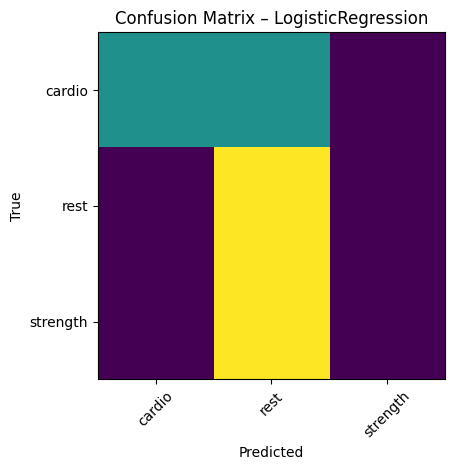

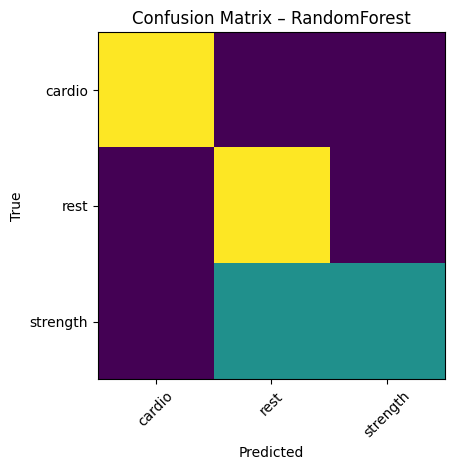

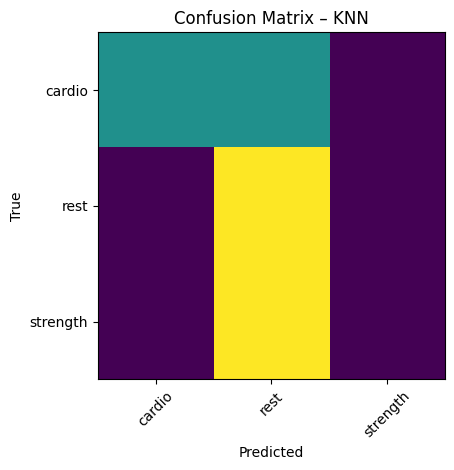

In [7]:
# confusion matrices for each model
for name, y_pred in preds.items():
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    plt.imshow(cm)
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(range(len(le.classes_)), le.classes_, rotation=45)
    plt.yticks(range(len(le.classes_)), le.classes_)
    plt.tight_layout()
    plt.show()


In [108]:
# Save results table
res_df.to_csv("model_results.csv", index=False)
files.download("model_results.csv")

# Train best model on all data and save for reuse
best_name = res_df.iloc[0]["model"]
best_model = Pipeline(steps=[("prep", preprocess), ("model", models[best_name])])
best_model.fit(X, y_enc)

joblib.dump({"pipeline": best_model, "label_classes": le.classes_}, f"{best_name}_model.pkl")
files.download(f"{best_name}_model.pkl")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [102]:
best_name = res_df.iloc[0]["model"]
print("===== Model Ranking =====")
print(res_df.to_string(index=False))
print("\nBest model:", best_name)

# detailed report for the best model on the test set
best_pipe = Pipeline(steps=[("prep", preprocess), ("model", models[best_name])])
best_pipe.fit(X_train, y_train)
y_pred_best = best_pipe.predict(X_test)
print("\nClassification report:\n")
print(classification_report(y_test, y_pred_best, target_names=list(le.classes_)))


===== Model Ranking =====
             model  accuracy  macro_f1
      RandomForest  0.833333  0.822222
LogisticRegression  0.500000  0.412698
               KNN  0.500000  0.412698

Best model: RandomForest

Classification report:

              precision    recall  f1-score   support

      cardio       1.00      1.00      1.00         2
        rest       0.67      1.00      0.80         2
    strength       1.00      0.50      0.67         2

    accuracy                           0.83         6
   macro avg       0.89      0.83      0.82         6
weighted avg       0.89      0.83      0.82         6



In [103]:
import pandas as pd
import numpy as np

# Example input (change values to test)
new_day = {
    "sleep_hours": 3,
    "soreness_1_5": 5,
    "stress_1_5": 3,
    "energy_level_1_5": 1,
    "motivation_1_5": 1,
    "sickness_level_0_3": 3,
    "time_available_today_min": 0,        # no time for workout
    "bedtime_hour_min": 30,               # 12:30 AM, 30 minutes after midnight
    "wake_time_hour_min": 600,            # 10:00 AM, 600 minutes after midnight
    "strength_workout_yesterday_bin": 1, # did strength yesterday
    "cardio_workout_yesterday_bin": 0, # no cardio yesterday
    "rest_yesterday_bin": 0,
    "workday_today_bin": 1, # have work for the day
    "injured_bin": 0
}

# Convert to DataFrame and match model’s expected column order
X_new = pd.DataFrame([new_day])[pipe.named_steps["prep"].transformers_[0][2]]

# if injured, sick, or too little time, rest automatically
if new_day["injured_bin"] == 1 or new_day["sickness_level_0_3"] >= 2 or new_day["time_available_today_min"] < 60:
    print("Recommended workout: rest")
else:
    prediction = pipe.predict(X_new)[0]
    label = le.inverse_transform([prediction])[0]
    print("Recommended workout:", label)



Recommended workout: rest


In [104]:

new_day = {
    "sleep_hours": 8.5,
    "soreness_1_5": 1,
    "stress_1_5": 1,
    "energy_level_1_5": 5,
    "motivation_1_5": 5,
    "sickness_level_0_3": 0,
    "time_available_today_min": 60,
    "bedtime_hour_min": 0,
    "wake_time_hour_min": 540,
    "strength_workout_yesterday_bin": 1,
    "cardio_workout_yesterday_bin": 0,
    "rest_yesterday_bin": 1,
    "workday_today_bin": 1,
    "injured_bin": 0
}

X_new = pd.DataFrame([new_day])[pipe.named_steps["prep"].transformers_[0][2]]

if new_day["injured_bin"] == 1 or new_day["sickness_level_0_3"] >= 2 or new_day["time_available_today_min"] < 60:
    print("Recommended workout: rest")
else:
    prediction = pipe.predict(X_new)[0]
    label = le.inverse_transform([prediction])[0]
    print("Recommended workout:", label)



Recommended workout: cardio


In [105]:
# same condition as above, except there is injury
new_day = {
    "sleep_hours": 8.5,
    "soreness_1_5": 1,
    "stress_1_5": 1,
    "energy_level_1_5": 5,
    "motivation_1_5": 5,
    "sickness_level_0_3": 0,
    "time_available_today_min": 180,
    "bedtime_hour_min": 0,
    "wake_time_hour_min": 540,
    "strength_workout_yesterday_bin": 1,
    "cardio_workout_yesterday_bin": 0,
    "rest_yesterday_bin": 1,
    "workday_today_bin": 1,
    "injured_bin": 1                # injured
}

X_new = pd.DataFrame([new_day])[pipe.named_steps["prep"].transformers_[0][2]]

if new_day["injured_bin"] == 1 or new_day["sickness_level_0_3"] >= 2 or new_day["time_available_today_min"] < 60:
    print("Recommended workout: rest")
else:
    prediction = pipe.predict(X_new)[0]
    label = le.inverse_transform([prediction])[0]
    print("Recommended workout:", label)


Recommended workout: rest


In [106]:
new_day = {
    "sleep_hours": 12,
    "soreness_1_5": 1,
    "stress_1_5": 1,
    "energy_level_1_5": 5,
    "motivation_1_5": 4,
    "sickness_level_0_3": 1,
    "time_available_today_min": 90,
    "bedtime_hour_min": 30,
    "wake_time_hour_min": 510,
    "strength_workout_yesterday_bin": 0,
    "cardio_workout_yesterday_bin": 1,
    "rest_yesterday_bin": 1,
    "workday_today_bin": 0,
    "injured_bin": 0
}

X_new = pd.DataFrame([new_day])[pipe.named_steps["prep"].transformers_[0][2]]

if new_day["injured_bin"] == 1 or new_day["sickness_level_0_3"] >= 2 or new_day["time_available_today_min"] < 60:
    print("Recommended workout: rest")
else:
    prediction = pipe.predict(X_new)[0]
    label = le.inverse_transform([prediction])[0]
    print("Recommended workout:", label)


Recommended workout: strength


In [107]:
# same condition as above, but lets say someone is very sick

new_day = {
    "sleep_hours": 13,
    "soreness_1_5": 1,
    "stress_1_5": 1,
    "energy_level_1_5": 5,
    "motivation_1_5": 4,
    "sickness_level_0_3": 3,
    "time_available_today_min": 90,
    "bedtime_hour_min": 30,
    "wake_time_hour_min": 510,
    "strength_workout_yesterday_bin": 0,
    "cardio_workout_yesterday_bin": 1,
    "rest_yesterday_bin": 1,
    "workday_today_bin": 0,
    "injured_bin": 0
}


X_new = pd.DataFrame([new_day])[pipe.named_steps["prep"].transformers_[0][2]]

if new_day["injured_bin"] == 1 or new_day["sickness_level_0_3"] >= 2 or new_day["time_available_today_min"] < 60:
    print("Recommended workout: rest")
else:
    prediction = pipe.predict(X_new)[0]
    label = le.inverse_transform([prediction])[0]
    print("Recommended workout:", label)

Recommended workout: rest
